In [ ]:
!pip install datasets timm tqdm torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
train_dataset_path = "/content/drive/MyDrive/deepfake/train"
val_dataset_path = "/content/drive/MyDrive/deepfake/val"
test_dataset_path = "/content/drive/MyDrive/deepfake/test"

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        real_dir = os.path.join(root_dir, 'real')
        for img_name in os.listdir(real_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(real_dir, img_name))
                self.labels.append(0)

        fake_dir = os.path.join(root_dir, 'fake')
        for img_name in os.listdir(fake_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(fake_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

def train_model():
    BATCH_SIZE = 16  # Increased as ResNet50 uses less memory
    EPOCHS = 10
    LEARNING_RATE = 0.001  # Increased for ResNet50

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = DeepfakeDataset(root_dir=train_dataset_path, transform=transform)
    val_dataset = DeepfakeDataset(root_dir=val_dataset_path, transform=transform)
    test_dataset = DeepfakeDataset(root_dir=test_dataset_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Load ResNet50 with pretrained weights
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    # Modify final layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        print(f'Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%')

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss/len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%')
        scheduler.step(epoch_val_loss)

        # Plot metrics
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Losses over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Accuracies over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'training_metrics_epoch_{epoch}.png')
        plt.close()

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': epoch_val_acc,
            }, 'resnet50_best_model.pth')
            print(f'Saved new best model with validation accuracy: {epoch_val_acc:.2f}%')

if __name__ == '__main__':
    train_model()

Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.5MB/s]



Epoch 1/10


Training: 100%|██████████| 25/25 [06:42<00:00, 16.12s/it]


Training Loss: 0.0806, Accuracy: 98.00%


Validation: 100%|██████████| 7/7 [01:09<00:00,  9.96s/it]


Validation Loss: 1.9087, Accuracy: 15.00%
Saved new best model with validation accuracy: 15.00%

Epoch 2/10


Training: 100%|██████████| 25/25 [04:58<00:00, 11.94s/it]


Training Loss: 0.0004, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:22<00:00,  3.24s/it]


Validation Loss: 0.8170, Accuracy: 48.00%
Saved new best model with validation accuracy: 48.00%

Epoch 3/10


Training: 100%|██████████| 25/25 [04:58<00:00, 11.94s/it]


Training Loss: 0.0518, Accuracy: 99.25%


Validation: 100%|██████████| 7/7 [00:22<00:00,  3.17s/it]


Validation Loss: 4.8042, Accuracy: 50.00%
Saved new best model with validation accuracy: 50.00%

Epoch 4/10


Training: 100%|██████████| 25/25 [04:58<00:00, 11.93s/it]


Training Loss: 0.0437, Accuracy: 99.25%


Validation: 100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


Validation Loss: 0.3774, Accuracy: 93.00%
Saved new best model with validation accuracy: 93.00%

Epoch 5/10


Training: 100%|██████████| 25/25 [05:08<00:00, 12.34s/it]


Training Loss: 0.2759, Accuracy: 95.00%


Validation: 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]


Validation Loss: 117.4818, Accuracy: 50.00%

Epoch 6/10


Training: 100%|██████████| 25/25 [05:10<00:00, 12.41s/it]


Training Loss: 0.0269, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


Validation Loss: 3.9142, Accuracy: 44.00%

Epoch 7/10


Training: 100%|██████████| 25/25 [05:05<00:00, 12.21s/it]


Training Loss: 0.0030, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:22<00:00,  3.19s/it]


Validation Loss: 1.4686, Accuracy: 32.00%

Epoch 8/10


Training: 100%|██████████| 25/25 [05:01<00:00, 12.07s/it]


Training Loss: 0.0018, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:22<00:00,  3.19s/it]


Validation Loss: 2.0429, Accuracy: 27.00%

Epoch 9/10


Training: 100%|██████████| 25/25 [05:09<00:00, 12.37s/it]


Training Loss: 0.0015, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


Validation Loss: 3.8814, Accuracy: 41.00%

Epoch 10/10


Training: 100%|██████████| 25/25 [05:05<00:00, 12.21s/it]


Training Loss: 0.0034, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:21<00:00,  3.14s/it]


Validation Loss: 2.4401, Accuracy: 33.00%


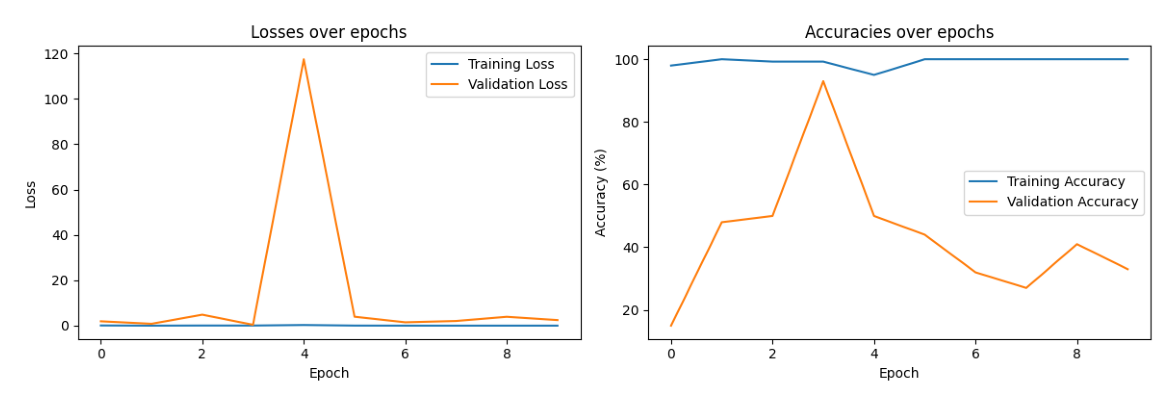

In [ ]:
# Load and display the final epoch's metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('training_metrics_epoch_9.png')  # Assuming 10 epochs (0-9)
plt.figure(figsize=(15,5))
plt.imshow(img)
plt.axis('off')
plt.show()

# Sample Prediction

In [ ]:
def predict_image(image_path, model_path):
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   # Load model
   model = models.resnet50()
   model.fc = nn.Linear(model.fc.in_features, 2)
   model.load_state_dict(torch.load(model_path)['model_state_dict'])
   model.to(device)
   model.eval()

   # Transform image
   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Resize((224, 224), antialias=True),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

   # Load and preprocess image
   image = Image.open(image_path).convert('RGB')
   image = transform(image).unsqueeze(0).to(device)

   # Predict
   with torch.no_grad():
       output = model(image)
       _, predicted = torch.max(output, 1)
       prob = torch.softmax(output, 1)

   result = 'Fake' if predicted.item() == 1 else 'Real'
   confidence = prob[0][predicted.item()].item() * 100

   return result, confidence

# Usage
result, confidence = predict_image('/content/drive/MyDrive/deepfake/test/real/311.png', 'resnet50_best_model.pth')
print(f'Prediction: {result} (Confidence: {confidence:.2f}%)')

<ipython-input-6-071de14eb1ab>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


Prediction: Fake (Confidence: 59.44%)


# Confusion Matrix

<ipython-input-7-a9a250e39931>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_best_model.pth')['model_state_dict'])


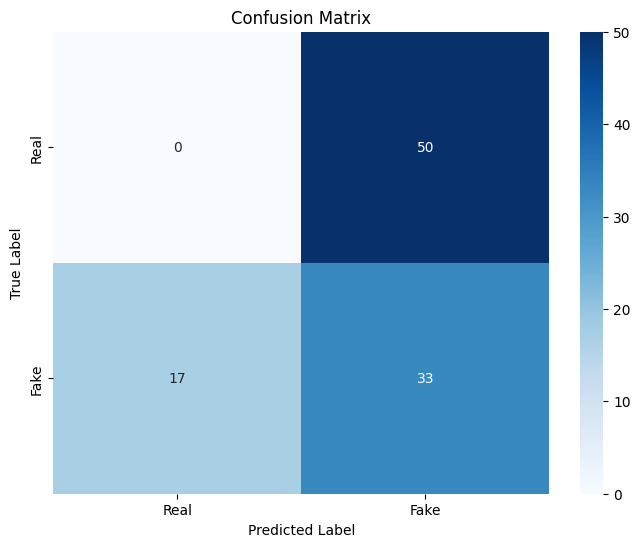


Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        50
        Fake       0.40      0.66      0.50        50

    accuracy                           0.33       100
   macro avg       0.20      0.33      0.25       100
weighted avg       0.20      0.33      0.25       100



In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader

# Dataset class
class TestDataset(Dataset):
   def __init__(self, test_dir, transform=None):
       self.test_dir = test_dir
       self.transform = transform
       self.images = []
       self.labels = []

       real_dir = os.path.join(test_dir, 'real')
       for img_name in os.listdir(real_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(real_dir, img_name))
               self.labels.append(0)

       fake_dir = os.path.join(test_dir, 'fake')
       for img_name in os.listdir(fake_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(fake_dir, img_name))
               self.labels.append(1)

   def __len__(self):
       return len(self.images)

   def __getitem__(self, idx):
       img_path = self.images[idx]
       image = Image.open(img_path).convert('RGB')
       label = self.labels[idx]

       if self.transform:
           image = self.transform(image)
       return image, label

# Data loading
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Resize((224, 224), antialias=True),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = TestDataset(test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('resnet50_best_model.pth')['model_state_dict'])
model = model.to(device)
model.eval()

# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
   for images, labels in test_loader:
       images = images.to(device)
       outputs = model(images)
       _, predicted = torch.max(outputs.data, 1)
       all_preds.extend(predicted.cpu().numpy())
       all_labels.extend(labels.numpy())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Real', 'Fake'],
           yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

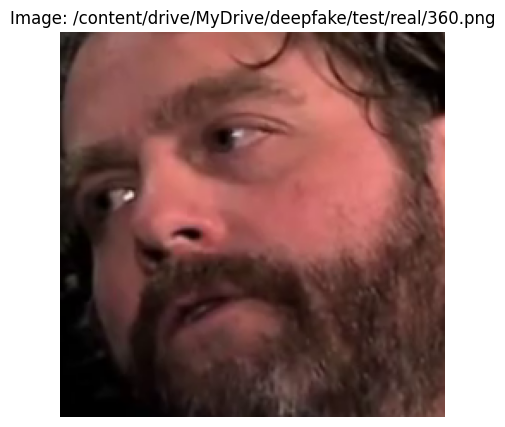

<ipython-input-9-1ae5c826c89f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


Prediction for /content/drive/MyDrive/deepfake/test/real/360.png: Fake (Confidence: 74.80%)


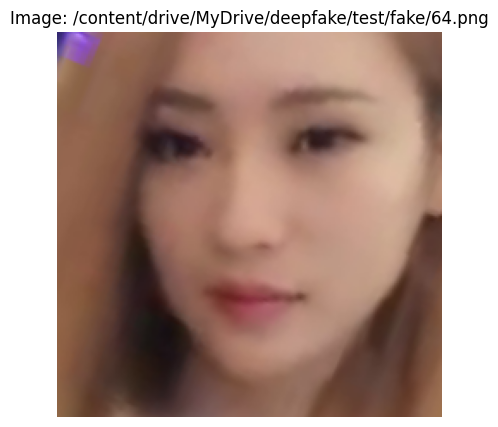

Prediction for /content/drive/MyDrive/deepfake/test/fake/64.png: Fake (Confidence: 72.57%)


In [ ]:
# display sample image and prediction

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example usage with two sample images
image_paths = ['/content/drive/MyDrive/deepfake/test/real/360.png', '/content/drive/MyDrive/deepfake/test/fake/64.png']  # Replace with actual paths

for image_path in image_paths:
    try:
        img = mpimg.imread(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {image_path}")
        plt.show()

        result, confidence = predict_image(image_path, 'resnet50_best_model.pth')
        print(f'Prediction for {image_path}: {result} (Confidence: {confidence:.2f}%)')
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")

In [ ]:
# display all prediction result

# Display all prediction results for the test dataset
print("Prediction Results for all test images:")
for i in range(len(all_preds)):
    print(f"Image {i+1}: Predicted - {('Fake' if all_preds[i] == 1 else 'Real')}, Actual - {('Fake' if all_labels[i] == 1 else 'Real')}")

Prediction Results for all test images:
Image 1: Predicted - Fake, Actual - Real
Image 2: Predicted - Fake, Actual - Real
Image 3: Predicted - Fake, Actual - Real
Image 4: Predicted - Fake, Actual - Real
Image 5: Predicted - Fake, Actual - Real
Image 6: Predicted - Fake, Actual - Real
Image 7: Predicted - Fake, Actual - Real
Image 8: Predicted - Fake, Actual - Real
Image 9: Predicted - Fake, Actual - Real
Image 10: Predicted - Fake, Actual - Real
Image 11: Predicted - Fake, Actual - Real
Image 12: Predicted - Fake, Actual - Real
Image 13: Predicted - Fake, Actual - Real
Image 14: Predicted - Fake, Actual - Real
Image 15: Predicted - Fake, Actual - Real
Image 16: Predicted - Fake, Actual - Real
Image 17: Predicted - Fake, Actual - Real
Image 18: Predicted - Fake, Actual - Real
Image 19: Predicted - Fake, Actual - Real
Image 20: Predicted - Fake, Actual - Real
Image 21: Predicted - Fake, Actual - Real
Image 22: Predicted - Fake, Actual - Real
Image 23: Predicted - Fake, Actual - Real
Ima